# Model

In [1]:
# | default_exp models.regional_growth_factor

In [2]:
# | export
import jax.numpy as jnp
import jax.scipy as jsp
from pyprojroot.here import here
import jax
from jax import vmap, jit
import matplotlib.pyplot as plt
import matplotlib as mpl
import pandas as pd
import jax.random as jrn

from isssm.typing import PGSSM, GLSSMState
from jaxtyping import Array, Float

from tensorflow_probability.substrates.jax.distributions import (
    NegativeBinomial as NBinom,
)

jax.config.update("jax_enable_x64", True)

## Monkey patches (account for missing observations)

### NBinom sampler is slow (https://github.com/tensorflow/probability/issues/1843)

In [3]:
# | export
def _call_sample_n_patched(self, sample_shape, seed, **kwargs):
    return self._sample_n(sample_shape, seed)


def _sample_n_patched(self, n, seed=None):
    # Here we use the fact that if:
    # lam ~ Gamma(concentration=total_count, rate=(1-probs)/probs)
    # then X ~ Poisson(lam) is Negative Binomially distributed.
    logits = self._logits_parameter_no_checks()
    gamma_seed, poisson_seed = jrn.split(seed)
    r = self.total_count
    mu = jnp.exp(logits) * r
    gamma_sample = mu / r * jrn.gamma(gamma_seed, r, (mu / r).shape)
    return jrn.poisson(poisson_seed, gamma_sample)


NBinom._sample_n = _sample_n_patched
NBinom._call_sample_n = _call_sample_n_patched

### Nans

In [4]:
# | export
def account_for_nans(model: PGSSM, y, missing_indices) -> tuple[PGSSM, Float]:
    # only works for Poisson!
    # missing_indices = jnp.isnan(y)

    y_missing = jnp.nan_to_num(y, nan=0.0)

    v = model.v.at[missing_indices].set(0.0)
    B = model.B.at[missing_indices].set(0.0)

    xi_missing = jnp.ones_like(y).at[missing_indices].set(0.0)[..., None]
    xi = jnp.concatenate([xi_missing, model.xi], -1)

    def missing_dist(s, xi):
        xi_missing, old_xi = xi[..., 0], xi[..., 1:]
        old_dist = model.dist(s, old_xi)
        # if xi == 0. the logits becomes -inf, so dist is dirac_0
        return NBinom(
            old_dist.total_count, logits=old_dist.logits + jnp.log(xi_missing)
        )

    model_missing = PGSSM(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=v,
        B=B,
        dist=missing_dist,
        xi=xi,
    )

    return model_missing, y_missing

In [5]:
# | export
# log weights monkey patch
# nansum to account for missing values
# explicitly assumes that s_t = z_t!

from isssm.util import MVN_degenerate as MVN
import isssm.importance_sampling


def log_weights_t(
    s_t: Float[Array, "p"],  # signal
    y_t: Float[Array, "p"],  # observation
    xi_t: Float[Array, "p"],  # parameters
    dist,  # observation distribution
    z_t: Float[Array, "p"],  # synthetic observation
    Omega_t: Float[Array, "p p"],  # synthetic observation covariance, assumed diagonal
) -> Float:  # single log weight
    """Log weight for a single time point."""
    p_ys = dist(s_t, xi_t).log_prob(y_t).sum()

    # omega_t = jnp.sqrt(jnp.diag(Omega_t))
    # g_zs = MVN_diag(s_t, omega_t).log_prob(z_t).sum()
    g_zs = jnp.sum(
        jnp.nan_to_num(MVN(s_t, Omega_t).log_prob(z_t), nan=0.0, neginf=0.0, posinf=0.0)
    )

    return p_ys - g_zs


def log_weights(
    s: Float[Array, "n+1 p"],  # signals
    y: Float[Array, "n+1 p"],  # observations
    dist,  # observation distribution
    xi: Float[Array, "n+1 p"],  # observation parameters
    z: Float[Array, "n+1 p"],  # synthetic observations
    Omega: Float[Array, "n+1 p p"],  # synthetic observation covariances:
) -> Float:  # log weights
    """Log weights for all time points"""
    p_ys = dist(s, xi).log_prob(y).sum()

    # avoid triangular solve problems
    # omega = jnp.sqrt(vmap(jnp.diag)(Omega))
    # g_zs = MVN_diag(s, omega).log_prob(z).sum()
    # g_zs = jnp.nansum(MVN(s, Omega).log_prob(z))
    g_zs = jnp.sum(
        jnp.nan_to_num(MVN(s, Omega).log_prob(z), nan=0.0, neginf=0.0, posinf=0.0)
    )

    return p_ys - g_zs


isssm.importance_sampling.log_weights = log_weights
isssm.importance_sampling.log_weights_t = log_weights_t

In [6]:
# | export
# LA monkey patch
from isssm.kalman import kalman, smoothed_signals
from isssm.typing import GLSSM, GLSSMProposal, ConvergenceInformation
from isssm.laplace_approximation import default_link, vvmap, vdiag
from jax.scipy.optimize import minimize
from functools import partial
from isssm.util import converged
from jax import jacfwd, hessian, jacrev
from jax.lax import while_loop
import isssm.laplace_approximation


def _initial_guess(xi_t, y_t, dist, link=jnp.log):
    result = minimize(
        lambda s_ti: -dist(s_ti, xi_t).log_prob(y_t).sum(),
        jnp.concatenate((jnp.atleast_1d(link(y_t.sum())), jnp.zeros(3))),
        method="BFGS",
    )
    return jnp.squeeze(result.x)


def laplace_approximation(
    y: Float[Array, "n+1 p"],  # observation
    model: PGSSM,
    n_iter: int,  # number of iterations
    log_lik=None,  # log likelihood function
    d_log_lik=None,  # derivative of log likelihood function
    dd_log_lik=None,  # second derivative of log likelihood function
    eps: Float = 1e-5,  # precision of iterations
    link=default_link,  # default link to use in initial guess
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    u, A, D, Sigma0, Sigma, v, B, dist, xi = model
    np1, p, m = B.shape

    # s_init = vmap(partial(_initial_guess, dist=dist, link=link))(xi, y)
    # missing values have zero obs. -> 0.
    # s_init = jnp.hstack(
    #    (jnp.log(y.sum(axis=1, keepdims=True) + 1.0), jnp.zeros((np1, 3)))
    # )
    s_init = jnp.nan_to_num(jnp.log(y / model.xi[..., -1]), nan=0.0, neginf=0.0)

    def default_log_lik(s_ti, xi_ti, y_ti):
        return jnp.nansum(dist(s_ti, xi_ti).log_prob(y_ti))

    if log_lik is None:
        log_lik = default_log_lik

    if d_log_lik is None:
        d_log_lik = jacfwd(log_lik, argnums=0)
    if dd_log_lik is None:
        dd_log_lik = jacrev(d_log_lik, argnums=0)

    vd_log_lik = jit(vvmap(d_log_lik))
    vdd_log_lik = jit(vvmap(dd_log_lik))

    def _break(val):
        _, i, z, Omega, z_old, Omega_old = val

        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        all_converged = jnp.logical_and(z_converged, Omega_converged)

        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(all_converged, iteration_limit_reached)

    def _iteration(val):
        s, i, z_old, Omega_old, _, _ = val

        grad = vd_log_lik(s, xi, y)
        Gamma = -vdd_log_lik(s, xi, y)
        # assume hessian is diagonal
        Gamma_inv = jnp.nan_to_num(1.0 / Gamma, neginf=0.0, posinf=0.0)
        Omega = vdiag(Gamma_inv)

        z = s + grad * Gamma_inv
        approx_glssm = GLSSM(u, A, D, Sigma0, Sigma, v, B, Omega)

        filtered = kalman(z, approx_glssm)
        s_new = smoothed_signals(filtered, z, approx_glssm)

        return s_new, i + 1, z, Omega, z_old, Omega_old

    empty_z = jnp.empty_like(s_init)
    empty_Omega = jnp.empty((np1, p, p))
    init = (s_init, 0, empty_z, empty_Omega, empty_z, empty_Omega)

    _keep_going = lambda *args: jnp.logical_not(_break(*args))
    _, n_iters, z, Omega, z_old, Omega_old = while_loop(_keep_going, _iteration, init)

    final_proposal = GLSSMProposal(u, A, D, Sigma0, Sigma, v, B, Omega, z)
    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )
    return final_proposal, information


isssm.laplace_approximation._initial_guess = _initial_guess
isssm.laplace_approximation.laplace_approximation = laplace_approximation

In [7]:
# | export
# MEIS monkey patch
import jax.random as jrn
from jaxtyping import PRNGKeyArray
from isssm.importance_sampling import normalize_weights, log_weights_t
from isssm.kalman import simulation_smoother
import isssm.modified_efficient_importance_sampling

optimal_parameters = isssm.modified_efficient_importance_sampling.optimal_parameters


def modified_efficient_importance_sampling(
    y: Float[Array, "n+1 p"],  # observations
    model: PGSSM,  # model
    z_init: Float[Array, "n+1 p"],  # initial z estimate
    Omega_init: Float[Array, "n+1 p p"],  # initial Omega estimate
    n_iter: int,  # number of iterations
    N: int,  # number of samples
    key: PRNGKeyArray,  # random key
    eps: Float = 1e-5,  # convergence threshold
) -> tuple[GLSSMProposal, ConvergenceInformation]:
    z, Omega = z_init, Omega_init

    np1, p, m = model.B.shape

    key, crn_key = jrn.split(key)

    v_norm_w = vmap(normalize_weights)
    dist = model.dist
    lw_t = vmap(
        vmap(lambda s, y, xi, z, Omega: log_weights_t(s, y, xi, dist, z, Omega)),
        (0, None, None, None, None),
    )

    def _break(val):
        i, z, Omega, z_old, Omega_old = val

        # in first iteration we don't have old values, converged is True for NaNs
        z_converged = jnp.logical_and(converged(z, z_old, eps), i > 0)
        Omega_converged = jnp.logical_and(converged(Omega, Omega_old, eps), i > 0)
        iteration_limit_reached = i >= n_iter

        return jnp.logical_or(
            jnp.logical_and(z_converged, Omega_converged), iteration_limit_reached
        )

    def _iteration(val):
        i, z, Omega, _, _ = val
        glssm_approx = GLSSM(
            model.u,
            model.A,
            model.D,
            model.Sigma0,
            model.Sigma,
            model.v,
            model.B,
            Omega,
        )
        sim_signal = simulation_smoother(glssm_approx, z, N, crn_key)

        log_weights = lw_t(sim_signal, y, model.xi, z, Omega)
        log_p = dist(sim_signal, model.xi).log_prob(y).sum(axis=-1)
        wls_estimate = vmap(optimal_parameters, (1, 1, 1), 0)(
            sim_signal, v_norm_w(log_weights), log_p
        )

        a = wls_estimate[:, 0]
        b = wls_estimate[:, 1 : (p + 1)]
        c = wls_estimate[:, (p + 1) :]
        c_inv = jnp.nan_to_num(1 / c, nan=0.0, posinf=0.0, neginf=0.0)

        z_new = b * c_inv
        Omega_new = vmap(jnp.diag)(c_inv)

        return i + 1, z_new, Omega_new, z, Omega

    _keep_going = lambda *args: jnp.logical_not(_break(*args))

    n_iters, z, Omega, z_old, Omega_old = while_loop(
        _keep_going,
        _iteration,
        (0, z_init, Omega_init, jnp.empty_like(z_init), jnp.empty_like(Omega_init)),
    )

    proposal = GLSSMProposal(
        u=model.u,
        A=model.A,
        D=model.D,
        Sigma0=model.Sigma0,
        Sigma=model.Sigma,
        v=model.v,
        B=model.B,
        Omega=Omega,
        z=z,
    )

    delta_z = jnp.max(jnp.abs(z - z_old))
    delta_Omega = jnp.max(jnp.abs(Omega - Omega_old))
    information = ConvergenceInformation(
        converged=jnp.logical_and(
            converged(z, z_old, eps), converged(Omega, Omega_old, eps)
        ),
        n_iter=n_iters,
        delta=jnp.max(jnp.array([delta_z, delta_Omega])),
    )

    return proposal, information


isssm.modified_efficient_importance_sampling.modified_efficient_importance_sampling = (
    modified_efficient_importance_sampling
)

In [8]:
# | export
# monkey patch gnll to handle nans
vmm = vmap(jnp.matmul, (0, 0))
from isssm.util import MVN_degenerate as MVN
import isssm.estimation


def gnll(
    y: Float[Array, "n+1 p"],  # observations $y_t$
    x_pred: Float[Array, "n+1 m"],  # predicted states $\hat X_{t+1\bar t}$
    Xi_pred: Float[Array, "n+1 m m"],  # predicted state covariances $\Xi_{t+1\bar t}$
    B: Float[Array, "n+1 p m"],  # state observation matrices $B_{t}$
    Omega: Float[Array, "n+1 p p"],  # observation covariances $\Omega_{t}$
) -> Float:  # gaussian negative log-likelihood
    """Gaussian negative log-likelihood"""
    y_pred = vmm(B, x_pred)
    Psi_pred = vmm(vmm(B, Xi_pred), jnp.transpose(B, (0, 2, 1))) + Omega

    return jnp.sum(
        jnp.nan_to_num(
            -MVN(y_pred, Psi_pred).log_prob(y), nan=0.0, posinf=0.0, neginf=0.0
        )
    )


isssm.estimation.gnll = gnll

## Hyperparameters

In [9]:
# | export

key = jrn.PRNGKey(452342342345)
n_iterations = 20
N_mle = 1000
N_meis = 2000
N_posterior = 10000

# same as in FCH
percentiles_of_interest = jnp.array(
    [0.01, 0.025, *(0.05 * jnp.arange(1, 20)), 0.975, 0.99]
)

In [10]:
mpl.rcParams["figure.figsize"] = (20, 6)


## States
Let $\bar r_t = \log \bar \rho_t$ be the average growth factor (on the log scale) across all counties and $u_t^c$ be the deviation of county $c$'s log-growth factor for $\bar r_t$. 
We model $\bar r_t$ following a random walk and $u^\cdot_t$ following an $\text{VAR}(1)$ process with transition matrix $\alpha I$ and spatial correlation $\Omega$.

Thus we have
$$
\begin{align*}
\bar r_{t + 1} &= \bar r_{t} + \varepsilon_{t + 1}^\rho \\
u^c_{t + 1} &= \alpha u^c_t + \varepsilon_{t + 1}^c
\end{align*}
$$

with $\text{Var}(\varepsilon_{t + 1}^\rho) = \sigma^2_\rho$ and $\text{Cov}(\varepsilon_{t + 1}) = \Omega$. 
The covariance matrix of the stationary distribution is $\Sigma = \frac {1} {1 - \alpha^2} \Omega$.

In [11]:
# | export
def _state_model(r0, u0, alpha, s2_rho, Omega, n) -> GLSSMState:
    (K,) = u0.shape
    A = jnp.broadcast_to(
        jsp.linalg.block_diag(1, alpha * jnp.eye(K)), (n, K + 1, K + 1)
    )
    # Sigma0 = jsp.linalg.block_diag(s2_rho, 1 / (1 - alpha**2) * Omega)
    Sigma0 = jnp.eye(K + 1)
    Sigma = jsp.linalg.block_diag(s2_rho * jnp.eye(1), Omega)
    Sigma = jnp.broadcast_to(Sigma, (n, K + 1, K + 1))

    x0 = jnp.concatenate([r0, u0])
    D = jnp.broadcast_to(jnp.eye(K + 1), (n, K + 1, K + 1))
    u = jnp.zeros((n + 1, K + 1))
    u = u.at[0].set(x0)

    return GLSSMState(u, A, D, Sigma0, Sigma)

## Observations
The log growth factor in a region at time $t$, $r^c_t$, is given by the mean log growth factor $\bar r_t$ and the per-region deviation $u^c_t$.
Conditional on the log growth factors and past cases, cases are Negative Binomially distributed with shared overdispersion parameter $r$
$$
\begin{align*}
r^c_t &= \bar r_t + u^c_{t} \\
\lambda_t^c &= \exp(r^c_t) \sum_{d}p_{c,d} I_t^d \\
I^c_{t + 1} | I^c_{t}, \rho_t, u^c_t &\sim \text{NegBinom}(\underbrace{\lambda_t^c}_{\text{mean}}, \underbrace{r}_{\text{overdispersion}})
\end{align*}
$$

where the variance of the negative binomial distribution is $\mu + \frac{\mu^2}{r}$


In [12]:
# | export
from tensorflow_probability.substrates.jax.distributions import Poisson


def _observation_model(obs: Float[Array, "n+2 K"], P: Float[Array, "K K"], r: Float):

    np2, p = obs.shape
    np1 = np2 - 1

    delayed_obs = obs[:-1]
    cases_adjusted = vmap(jnp.matmul, (None, 0))(P.T, delayed_obs)

    xi = jnp.concatenate(
        (jnp.full((np1, p, 1), r), cases_adjusted[:, :, None]), axis=-1
    )
    # xi = cases_adjusted

    def dist_obs_nb(signal, xi):
        r, sum_I = jnp.moveaxis(xi, -1, 0)
        return NBinom(r, logits=signal + jnp.log(sum_I) - jnp.log(r))

    def dist_obs_pois(signal, xi):
        sum_I = xi
        return Poisson(log_rate=signal + jnp.log(sum_I))

    B = jnp.hstack([jnp.ones((p, 1)), jnp.eye(p)])
    B = jnp.broadcast_to(B, (np1, p, p + 1))
    v = jnp.zeros((np1, p))

    return v, B, dist_obs_nb, xi

## Spatial Correlations

Suppose we have in county $c$ $S^c$ many new infections generated, which may be attributed to the same county or another one, $c'$ say.
Let $p_{c,c'}$ be the fraction of cases generated in county $c'$ (instead of in county $c$) and $p_{c,c} = 1 - \sum_{c' \neq c} p_{c,c'}$.


Let $P = \left(p_{c,c'}\right)_{c = 1, \dots, K, c' = 1,\dots, K}$.

Let $\tilde S^c = \sum p_{c,d} S^d$ be the number of cases generated in county $c$.

Then we are interested in 

$$
\begin{align*}
    \text{Cov}(\tilde S^c, \tilde S^{c'}) = \underbrace{\sigma^2}_{\text{Var}(S^c)} (\sum_{d} p_{c,d} p_{c',d}) = \sigma^2_{\text{spat}} (P P^T)_{c, c'}
\end{align*}
$$


To obtain $p_{c,c'}$ we use data on commuters $q_{c,c'}$ the fraction of socially insured employees that have their center of life in county $c$ but are registered to work in county $c'$. 

To account for non-working inhabitants (elderly, kids, ...) we introduce a constant $C \geq 1$ s.t. 
$$
p_{c,c'} = \bar q + (1 - \bar q)\frac{\mathbf 1 _{c \neq c'} q_{c,c'}}{ \sum_{d \neq c} q_{c,d} + C q_{c,c}},
$$
i.e. we blow up the proportion of "stay at home" by a constant $C$ (that is the same for all counties) and add a constant "socket" of travel $\bar q$ between the counties.


Finally we choose

$$
\Omega = \sigma^2_{\text{spat}}PP^T %+ \sigma^2_{\text{nugget}} I
$$

In [13]:
# | export
def _P(C, q, n_ij, n_tot) -> Float[Array, "K K"]:
    p, _ = n_ij.shape
    m_ij = n_ij + jnp.diag(C * n_tot - n_ij.sum(axis=1))
    normalize_rows = lambda x: x / x.sum(axis=1).reshape((-1, 1))
    return jnp.full((p, p), q / p) + (1 - q) * normalize_rows(m_ij)


## Parameters

$$
\theta = \left( \text{logit}(\alpha), \log \sigma^2_r, \log \sigma^2_{\text{spat}}, C, \log \mu \right)%\log \sigma^2_{\text{nugget}}, \log \mu \right)
$$


## Final Model

In [14]:
# | export
def growth_factor_model(theta, aux) -> PGSSM:

    logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1, log_r = theta
    # logit_alpha, log_s2_r, log_s2_spat, logit_q, log_Cm1 = theta
    obs, n_ij, n_tot = aux
    C = jnp.exp(log_Cm1) + 1

    np2, _ = obs.shape
    np1 = np2 - 1
    (K,) = n_tot.shape

    m = K + 1
    p = K
    l = K + 1

    alpha = jsp.special.expit(logit_alpha)
    s2_rho = jnp.exp(log_s2_r)
    s2_spat = jnp.exp(log_s2_spat)
    r = jnp.exp(log_r)
    # r = None
    q = jsp.special.expit(logit_q)

    P = _P(C, q, n_ij, n_tot)
    state = _state_model(
        jnp.zeros(1), jnp.zeros(K), alpha, s2_rho, s2_spat * P.T @ P, np1 - 1
    )
    obs = _observation_model(obs, P, r)

    return PGSSM(*state, *obs)

In [15]:
# | export
n_tot = jnp.array(
    pd.read_csv(here() / "data/processed/home_totals.csv").iloc[:, 2].to_numpy()
)
n_ij = (
    jnp.array(
        pd.read_csv(here() / "data/processed/incommuters.csv").iloc[:, -1].to_numpy()
    )
    .reshape((400, 400))
    .T
)

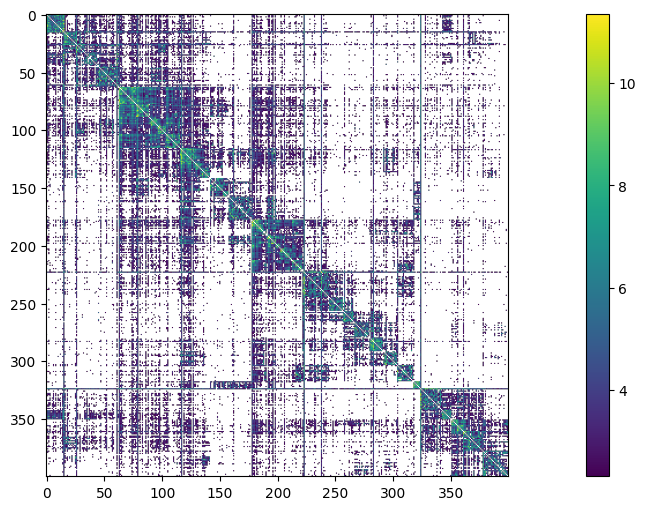

In [16]:
plt.imshow(jnp.log(n_ij))
plt.colorbar()
plt.show()

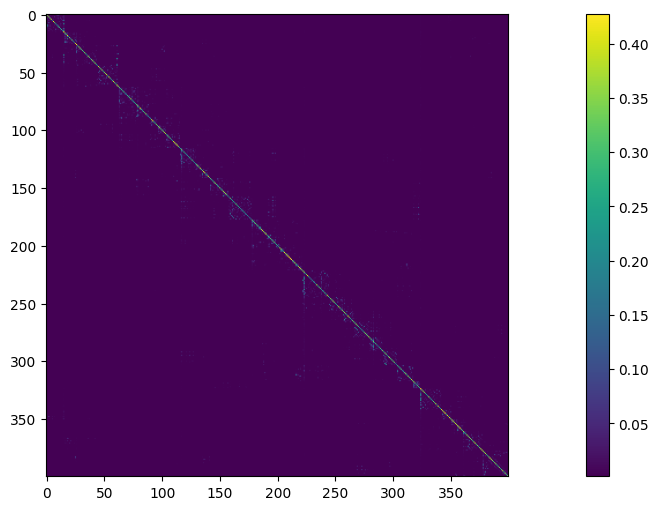

In [17]:
P = _P(1.0, 0.5, n_ij, n_tot)
plt.imshow(P)
plt.colorbar()
plt.show()

In [18]:
# | export
df_weekly_cases = pd.read_csv(here() / "data/processed/RKI_county_weekly.csv").pivot(
    index="date", columns="ags", values="cases"
)


cases_full = jnp.asarray(df_weekly_cases.to_numpy(), dtype=jnp.float64)
dates_full = df_weekly_cases.index.to_numpy()
ags_full = df_weekly_cases.columns.to_numpy()

In [19]:
# | export
def make_aux(date, cases_full, n_ij, n_tot, np1):
    iloc_of_date_in_index = jnp.where(dates_full == date)[0][0]
    cases = cases_full[iloc_of_date_in_index : iloc_of_date_in_index + np1 + 1]
    return cases, n_ij, n_tot

In [20]:
# | export
import jax.scipy as jsp


def par_to_theta(params):
    alpha, s2_r, s2_spat, q, C, r = params
    return jnp.array(
        [
            jsp.special.logit(alpha),
            jnp.log(s2_r),
            jnp.log(s2_spat),
            jsp.special.logit(q),
            jnp.log(C - 1),
            jnp.log(r),
        ]
    )


def theta_to_par(theta):
    alpha, s2_r, s2_spat, q, Cm1, r = theta
    return jnp.array(
        [
            jsp.special.expit(alpha),
            jnp.exp(s2_r),
            jnp.exp(s2_spat),
            jsp.special.expit(q),
            jnp.exp(Cm1) + 1,
            jnp.exp(r),
        ]
    )

In [21]:
par_manual = jnp.array(
    [
        0.5,
        0.01**2,
        0.01**2,
        0.5,
        2,
        100.0,
    ]
)
theta_manual = par_to_theta(par_manual)
np1 = 10
# aux = (cases_full[: np1 + 1], n_ij, n_tot)
dates = dates_full[14 + 1 : 14 + np1 + 1]
aux = make_aux(dates[0], cases_full, n_ij, n_tot, np1)
y = aux[0][1:]
y_nan = y.at[-1].set(jnp.nan)
missing_inds = jnp.isnan(y_nan)
_, y_miss = account_for_nans(
    growth_factor_model(theta_manual, aux), y_nan, missing_inds
)
_model_miss = lambda theta, aux: account_for_nans(
    growth_factor_model(theta, aux), y_nan, missing_inds
)[0]

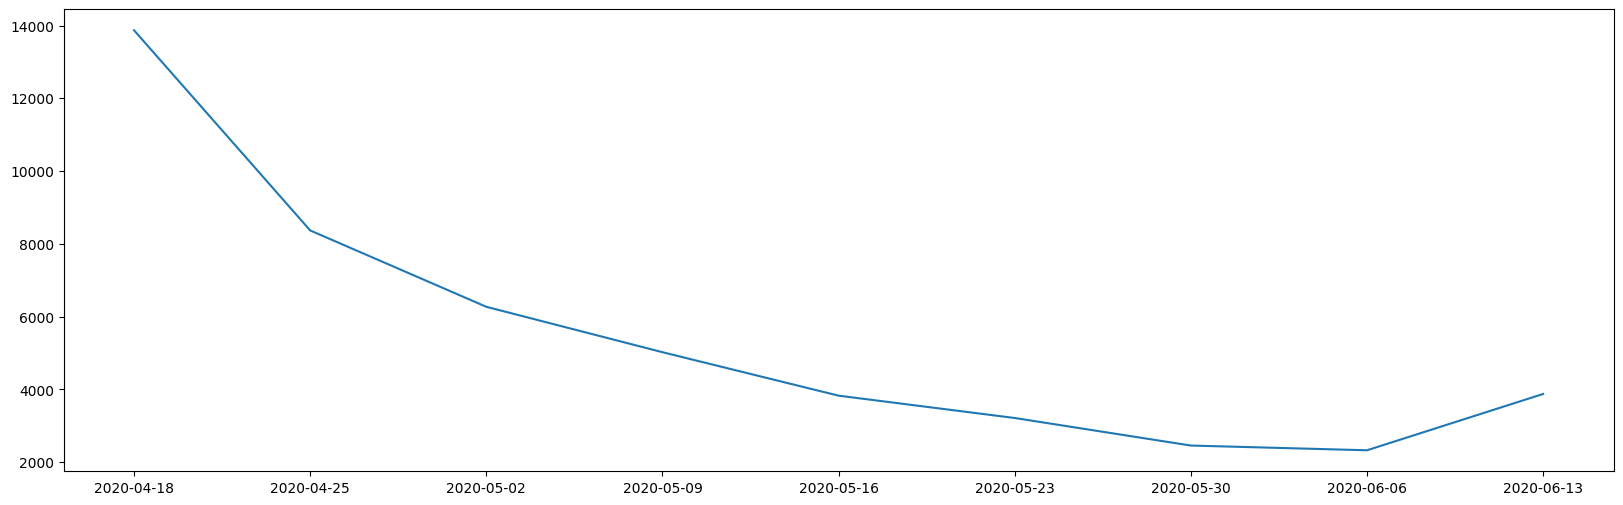

In [22]:
plt.plot(dates, y_nan.sum(axis=-1))
plt.show()

In [23]:
from ssm4epi.models.util import visualize_pgssm

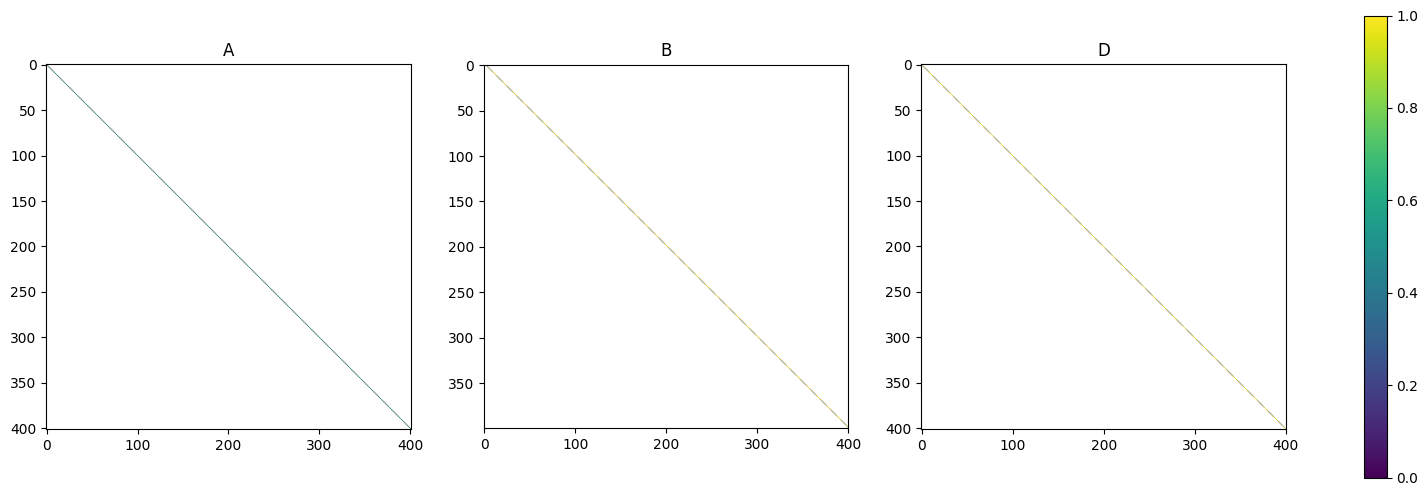

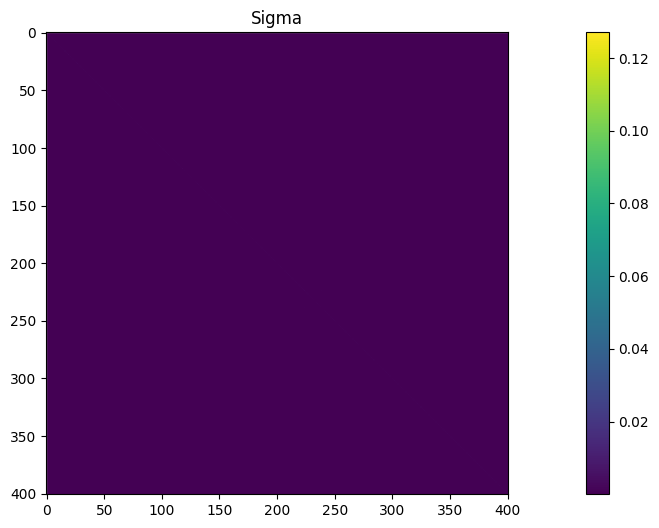

In [24]:
theta_manual = jnp.array([0.0, -2.063e00, -5.355e00, -4.511e-01, -5.711e-01, 7.932e-01])
model = growth_factor_model(theta_manual, aux)

visualize_pgssm(model)

In [25]:
from isssm.estimation import initial_theta
import jax

In [ ]:
with jax.log_compiles(True):
    theta0_result = initial_theta(
        y_miss,
        _model_miss,
        theta_manual,
        aux,
        n_iterations,
        options={"maxiter": 10},
    )
theta0 = theta0_result.x
theta0_result

KeyboardInterrupt: 

In [29]:
theta_to_par(theta0)

Array([0.6315257 , 0.12422706, 0.00492335, 0.08071057, 1.6486944 ,
       1.87779282], dtype=float64)

In [30]:
fitted_model = _model_miss(theta0, aux)

## LA

In [31]:
from isssm.laplace_approximation import laplace_approximation as LA

In [32]:
proposal_la, info_la = LA(y_miss, fitted_model, n_iterations)
info_la

ConvergenceInformation(converged=Array(True, dtype=bool), n_iter=Array(7, dtype=int64, weak_type=True), delta=Array(1.8598918e-09, dtype=float64))

In [33]:
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct

In [34]:
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y_miss,
    fitted_model,
    proposal_la.z,
    proposal_la.Omega,
    N_mle,
    subkey,
)

ess_pct(lw)

Array(0.14657491, dtype=float64)

## MEIS

In [35]:
from isssm.modified_efficient_importance_sampling import (
    modified_efficient_importance_sampling as MEIS,
)

In [36]:
key, subkey = jrn.split(key)
proposal_meis, info_meis = MEIS(
    y_miss, fitted_model, proposal_la.z, proposal_la.Omega, 10, int(1e3), subkey
)
info_meis

ConvergenceInformation(converged=Array(True, dtype=bool), n_iter=Array(3, dtype=int64, weak_type=True), delta=Array(nan, dtype=float64))

In [37]:
from isssm.importance_sampling import pgssm_importance_sampling, ess_pct

In [38]:
key, subkey = jrn.split(key)
samples, lw = pgssm_importance_sampling(
    y_miss,
    fitted_model,
    proposal_meis.z,
    proposal_meis.Omega,
    N_mle,
    subkey,
)

ess_pct(lw)

Array(nan, dtype=float64)

## Predictions


In [39]:
from isssm.importance_sampling import mc_integration, prediction

In [44]:
key, subkey = jrn.split(key)


def predict_total(x, s, y):
    y_county = y[-1]
    y_tot = jnp.minimum(y_county, n_tot).sum()[None]
    return jnp.concatenate([y_tot, y_county], axis=0)


preds = prediction(
    lambda x, s, y: predict_total(x, s, y),
    y_miss,
    proposal_la,
    fitted_model,
    1000,
    subkey,
    percentiles_of_interest,
    growth_factor_model(theta0, aux),
)

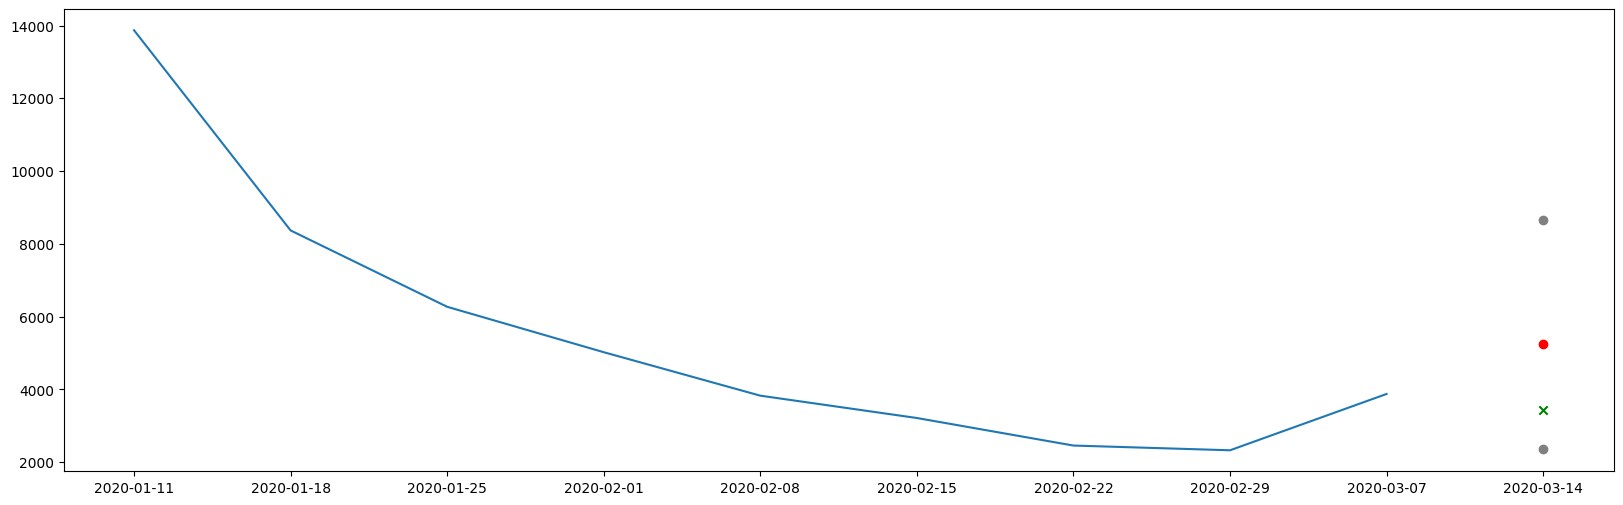

In [46]:
plt.plot(dates_full[1 : np1 + 1], y_nan.sum(axis=-1))
plt.scatter(dates_full[np1], preds[0][0], color="red")
plt.scatter(dates_full[np1], preds[2][1, 0], color="grey")
plt.scatter(dates_full[np1], preds[2][-2, 0], color="grey")
plt.scatter(dates_full[np1], y[-1].sum(), color="green", marker="x")
plt.show()

In [ ]:
# find index of Gütersloh / neighboring Warendorf
jnp.where(ags_full == 5754), jnp.where(ags_full == 5570)

In [ ]:
key, subkey = jrn.split(key)
county_index = jrn.randint(subkey, (1,), 0, 400)[0]
# Gütersloh
# county_index = 98


plt.title(f"ags = {ags_full[county_index]}")
plt.plot(dates_full[1 : np1 + 1], y_nan[:, county_index])
plt.scatter(dates_full[np1], preds[0][county_index + 1], color="red")
plt.scatter(dates_full[np1], preds[2][1, county_index + 1], color="grey")
plt.scatter(dates_full[np1], preds[2][-2, county_index + 1], color="grey")
plt.scatter(dates_full[np1], y[-1, county_index], color="green", marker="x")
plt.show()

In [ ]:
# | hide
import nbdev

nbdev.nbdev_export()